<a href="https://colab.research.google.com/github/jacksklar/pLLPRosetteDetector/blob/master/object_detection_DDN_5_12_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection Demo
Welcome to the object detection inference walkthrough!  This notebook will walk you step by step through the process of using a pre-trained model to detect objects in an image. Make sure to follow the [installation instructions](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/installation.md) before you start.

#notes

the folders are in /content/ from root, for example os.chdir("/content/models/research") would be the full path


tutorials
https://medium.com/coinmonks/part-1-2-step-by-step-guide-to-data-preparation-for-transfer-learning-using-tensorflows-object-ac45a6035b7a
https://medium.com/coinmonks/modelling-transfer-learning-using-tensorflows-object-detection-model-on-mac-692c8609be40

other tutorials
https://3sidedcube.com/guide-retraining-object-detection-models-tensorflow/
https://medium.com/coinmonks/modelling-transfer-learning-using-tensorflows-object-detection-model-on-mac-692c8609be40

Learn about pre-trained models
https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md

To edit files in colab

Unfortunately, it seems, colab do not support %load line magic (yet), and yet, you can see the file content using !cat your_file.py and then manually, copy the output contents, write them to a new cell and write %%writefile your_new_file_name.py at the top of the new cell to save this back to the instance. Note that, this will not be saved to your google drive yet.

Example:
!ls
output: colabData/

%%writefile something.py
print("everything's fine.")

!ls
output: colabData/ something.py

%run something.py
output: everything's fine.

In [0]:
pip install tensorflow-gpu

In [0]:
!git clone https://github.com/tensorflow/models.git

In [0]:
!sudo apt-get install protobuf-compiler python-pil python-lxml python-tk
!pip install --user Cython
!pip install --user contextlib2
!pip install --user jupyter
!pip install --user matplotlib

In [0]:
#compile protobuf
import os
os.chdir('models/research')
!protoc object_detection/protos/*.proto --python_out=.


In [0]:

#run the setup script
os.getcwd()
!python3.6 setup.py build

In [0]:
#add libraries to python path

!export PYTHONPATH=$PYTHONPATH:`pwd`:`pwd`/slim

# Imports

In [0]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile


from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.12.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.12.*.')


## Env setup

In [0]:
# This is needed to display the images.
%matplotlib inline

In [0]:
#change to the research dir
#os.chdir('research')



In [0]:
!ls

## Object detection imports
Here are the imports from the object detection module.

In [0]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

# Importing the labelled data from github

images and csv should be moved to a /data folder with the split and annotated images. 




In [0]:
#try to copy the file from gdrive?

#from google.colab import drive
#drive.mount('/content/gdrive')

os.chdir("/content/models/research")
!mkdir data

os.chdir("/content/gdrive/My Drive")
!cp data/* /content/models/research/data/

#TODO: delete this since we're cloning the folder from github




In [15]:

#clone the repo including the data files and the py files into the models folder

os.chdir("/content/models/research/")


#!rm -r pLLPRosetteDetector
!git clone https://github.com/jacksklar/pLLPRosetteDetector
  


Cloning into 'pLLPRosetteDetector'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 559 (delta 0), reused 0 (delta 0), pack-reused 556
Receiving objects: 100% (559/559), 17.77 MiB | 14.09 MiB/s, done.
Resolving deltas: 100% (33/33), done.


In [0]:
#move the data directory from the cloned repo into the models directory, and remove the gdrive download above

!mv /content/models/research/pLLPRosetteDetector/data /content/models/research/data/


In [0]:
#copy generate_tf_record py to the models folder

!cp /content/models/research/pLLPRosetteDetector/generate_tfrecord.py /content/models/research/generate_tfrecord.py



In [28]:
#make the tf record

!python generate_tfrecord.py --csv_input=/content/models/research/data/train_labels.csv  --output_path=/content/models/research/train.record

!python generate_tfrecord.py --csv_input=/content/models/research/data/test_labels.csv  --output_path=/content/models/research/test.record

Successfully created the TFRecords: /content/models/research/train.record
Successfully created the TFRecords: /content/models/research/test.record


In [29]:
#check the file sizes for the record files

!ls -l train.record #7072246 
!ls -l test.record #1728388 

#total size is ~8.8MB, image files together are ~8.3MB, so looks good!



-rw-r--r-- 1 root root 7072246 May 13 02:04 train.record
-rw-r--r-- 1 root root 1728388 May 13 02:04 test.record


In [0]:
!ls

#Setting up to train a pre-existing model


In [0]:
#make a folder to put the record files in

os.chdir("/content/models/research/")

!mkdir rosette_detect
!mv train.record test.record rosette_detect


# Model preparation 

## Variables

Any model exported using the `export_inference_graph.py` tool can be loaded here simply by changing `PATH_TO_FROZEN_GRAPH` to point to a new .pb file.  

By default we use an "SSD with Mobilenet" model here. See the [detection model zoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) for a list of other models that can be run out-of-the-box with varying speeds and accuracies.

In [0]:
# What model to download.
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('data', 'mscoco_label_map.pbtxt')

## Download Model

In [0]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

## Load a (frozen) Tensorflow model into memory.

In [0]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [0]:
os.chdir('object_detection')

## Loading label map
Label maps map indices to category names, so that when our convolution network predicts `5`, we know that this corresponds to `airplane`.  Here we use internal utility functions, but anything that returns a dictionary mapping integers to appropriate string labels would be fine

In [0]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

## Helper code

In [0]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Detection

In [0]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = 'test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [0]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[1], image.shape[2])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: image})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.int64)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

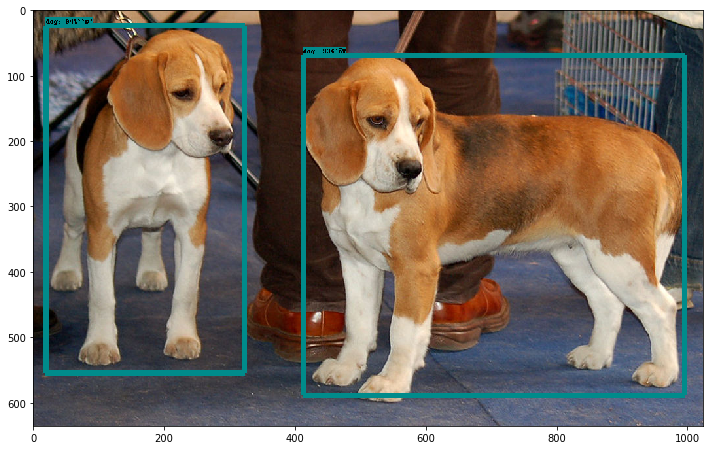

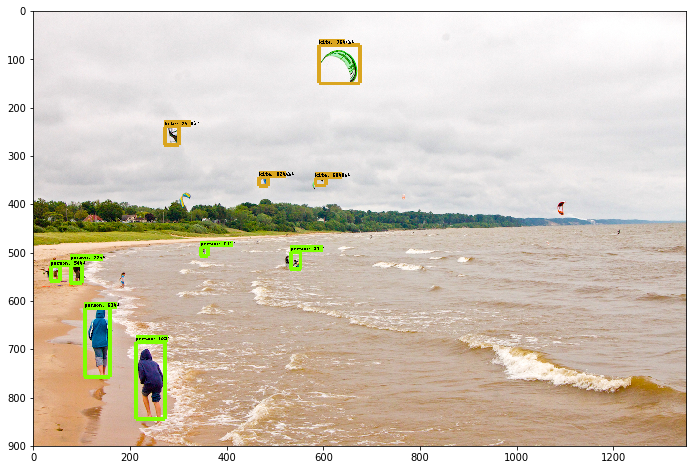

In [0]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np_expanded, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)